# Категоризация текста

## Предыстория

__Идея__: сделать классификацию постов по какому-то конечному количеству тем.

__Проблемы__: плохая фантазия (придумывать топики совсем не моё), желание собрать большой датасет, который не хочется размечать вручную (я не смогу отсмотреть вручную 15к постов).

Такие проблемы хорошо может решить задача, которую зарубежные коллеги называют _topic modelling_.
Изначально было найдено какое-то множество (вероятно, не универсальное) [подходов к этой задаче](https://www.frontiersin.org/articles/10.3389/fsoc.2022.886498/full). Вот, кстати, они:
* LDA
* NMF
* Top2Vec
* BERTopic

В итоге остановился на NMF как на относительно простом и понятном методе. Документ-терм матрицу для NMF сделал с помощью _tf-idf_.

Таким образом, наивный алгоритм дальнейших действий: собрать большое количество постов, прогнать их через _tf-idf_ + NMF, получить топ слов для какого-то заранее определённого количества тем. Полученным темам я придумаю названия.

## Сбор датасета

Данные ~влом вводить с помощью формочки~ быстрее собрать автоматически (да и так получится собрать больше), поэтому был написан краулер.
Написанный краулер - это своеобразный итеративный обход в ширину графа пользователей в ВК. У каждого пользователя берутся все его сообщества, у которых берётся топ-100 постов.
Из постов выкидываем те, которые совсем не имеют текста.

Для работы краулера нужна переменная окружения `VK_TOKEN`.
Для начала вспомогательные функции для работы с VK API:

In [87]:
import os
import vk_api

# creds
#token = os.getenv('VK_TOKEN')
# TODO: remove ASAP
token = ''
version = 5.131

vk_session = vk_api.VkApi(token=token)
vk = vk_session.get_api()

# `get_friends` - Get users friends' ids.
#    @user_id - User ID.
def get_friend_ids(user_id):
    try:
        friends = vk.friends.get(user_id=user_id, v=version)
        return friends['items']
    except vk_api.ApiError as err:
        return []

# `get_posts` - Get posts of group.
#    @group_id - ID of dedicated group.
#    @count - Number of posts.
def get_posts(group_id, count=100):
    try:
        posts = vk.wall.get(owner_id=-group_id, v=version, count=count)
        return posts['items']
    except vk_api.ApiError:
        return []
# `get_user_groups` - Get user groups (via subscriptions).
#    @user_id - ID of dedicated user.
def get_user_group_ids(user_id):
    try:
        subs = vk.users.getSubscriptions(user_id=user_id)
        return subs['groups']['items']
    except vk_api.ApiError:
        return []


Функции для вставки в БД (sqlite3):

In [88]:
import sqlite3

def create_posts_table(conn):
    conn.execute('''create table if not exists vk_posts (
        id int not null,
        owner_id bigint not null,
        text varchar(5000),
        primary key (id, owner_id)
    )''')

# `save_posts` - Save list of post object.
#    @posts - List of post objects.
def save_posts(conn, posts):
    if posts:
        conn.executemany('insert or ignore into vk_posts values(?, ?, ?)', \
                         list(map(lambda x: (x['id'], x['owner_id'], x['text']), posts)))
        conn.commit()
        
def clear_posts(conn):
    conn.execute('drop table if exists vk_posts')

Теперь всё готово для получения датасета. Пользователь, с которого начинается обход в ширину задаётся параметром `start_id`, нужное количество постов - `threshold`. __Для текущего пользователя (владельца токена) изначальный пользователь должен быть открыт!__

In [90]:
from collections import deque
from time import sleep
from tqdm.notebook import tqdm

# me btw
start_id = 126942672
threshold = 15_000

with tqdm(total=threshold) as pbar, sqlite3.connect('datasets/posts.db') as conn:
    clear_posts(conn)
    create_posts_table(conn)
    user_ids = deque([start_id])
    group_ids = deque()
    while threshold > 0:
        while not group_ids:
            user_id = user_ids.popleft()
            # replace user with his friends
            user_ids.extend(get_friend_ids(user_id))
            sleep(0.3)
            # now we can add user's groups
            group_ids.extend(get_user_group_ids(user_id))
            sleep(0.3)
        group_id = group_ids.popleft()
        posts = get_posts(group_id)
        non_empty_posts = list(filter(lambda x: len(x['text']) > 0 and len(x['text'].split()) > 100, posts))
        save_posts(conn, non_empty_posts)
        sleep(0.3)
        pbar.update(len(non_empty_posts))
        threshold -= len(non_empty_posts)

  0%|          | 0/15000 [00:00<?, ?it/s]

Не всегда при рендере ноутбука на других машинах нормально отображается progress bar, поэтому вот для истории мой скрин:

![progress_bar](images/progress_bar.png)

После бодрой игры в Overwatch данные были собраны. Проверим ещё валидность собранных данных.

Хорошо поможет индекс в таблице.

In [91]:
with sqlite3.connect('datasets/posts.db') as conn:
    cur = conn.execute('select count(*) from (select owner_id, id from vk_posts group by owner_id, id)')
    print(cur.fetchone())
    cur = conn.execute('select count(*) from vk_posts')
    print(cur.fetchone())

(14590,)
(14590,)


Получается, что у нас имеется почти 15000 уникальных постов с текстом. Мы почти готовы приступить к обучению.

## Разметка постов

В отличие от классического vanilla _20 newsgroup_, наши данные это настоящий хардкор из ITW постов.
Соответственно, чтобы дать модели максимально вылизанный текст, над текстом поста необходимо немного поработать.
Ограничимся следующими идеями:

* Список стоп-слов для _tf-idf_ на русском уже есть в `scikit`, но можно найти [немного побольше](https://github.com/stopwords-iso/stopwords-ru/blob/master/stopwords-ru.json).
* Всё равно какой-то треш останется. От него можно избавиться, выкинув слишком редкие слова (по большому счёту бесполезные) и слишком частые слова (служебные части речи и прочее, что мог не устранить наш стоп-лист).
* Мы будем иметь дело с великим и могучим русским языком. В нём есть падежи, преодолеть такую неприятность мог бы [pymystem3](https://github.com/nlpub/pymystem3), но он будет слишком медленным. Возьмем бюджетный аналог - [pymorph2](https://pymorphy2.readthedocs.io/en/stable/user/index.html).
* Можно отбрасывать посты, в которых слишком мало текста (условно, <100 слов). Возможно это сильно порежет датасет, но это решается перезапуском краулера с увеличенным порогом.
* Для получившихся топиков модель выделит топ слов. Их тоже можно будет _аккуратно_ убирать.

Все эти пункты направлены на уменьшение словаря, чтобы нас не постигло проклятие размерности.

In [4]:
import matplotlib.pyplot as plt

from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from tqdm.notebook import tqdm

import pymorphy2

import pandas as pd
import re
import sqlite3

morph = pymorphy2.MorphAnalyzer(lang='ru')

def process(text):
    only_rus = re.sub("[^а-яА-Я\s]", "", text)
    #return ''.join(m.lemmatize(only_rus))
    return ' '.join(morph.parse(x)[0].normal_form for x in only_rus.split())

posts = []

with sqlite3.connect('datasets/posts.db') as con:
    total = con.execute('select count(*) from vk_posts').fetchone()[0]
    with tqdm(total=total) as pbar:
        cursor = con.execute('select text from vk_posts')
        for x in cursor:
            processed = process(x[0])
            word_cnt = len(processed.split())
            if word_cnt >= 100:
                posts.append(processed)
            pbar.update(1)
            
print(f'total posts = {len(posts)}')

  0%|          | 0/14590 [00:00<?, ?it/s]

total posts = 12902


Весь сетап готов, можно смотреть на результаты.

Для наглядности будем рисовать диаграмму с топ-10 по популярности словами в каждом топике.

In [5]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 4, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    
def get_model(n_topics, stop_words, post_texts):
    vect = TfidfVectorizer(input='content', stop_words=stop_words, smooth_idf=False, analyzer='word', strip_accents='unicode')
    tfidf = vect.fit_transform(post_texts)
    features = vect.get_feature_names_out()
    
    nmf = NMF(
        n_components=n_topics,
        random_state=1,
        beta_loss="kullback-leibler",
        solver="mu",
        max_iter=1000,
        alpha_W=0.00005,
        alpha_H=0.00005,
        l1_ratio=0.5,
    )
    w = nmf.fit_transform(tfidf)
    
    return nmf, w, features, vect

C:\Users\mitya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['белыи', 'большои', 'важныи', 'воина', 'восемнадцатыи', 'восьмои', 'второи', 'выити', 'главныи', 'далекии', 'двадцатыи', 'двенадцатыи', 'девятнадцатыи', 'девятыи', 'деиствительно', 'десятыи', 'должныи', 'другои', 'еи', 'каждыи', 'какои', 'которои', 'которыи', 'маленькии', 'многочисленныи', 'мнои', 'мое', 'наити', 'неи', 'некоторыи', 'никакои', 'новыи', 'нужныи', 'одиннадцатыи', 'однои', 'первыи', 'подоиди', 'пожалуиста', 'поити', 'последнии', 'пятнадцатыи', 'пятыи', 'русскии', 'самои', 'самыи', 'своеи', 'сеаои', 'седьмои', 'сеичас', 'семнадцатыи', 'случаи', 'собои', 'советскии', 'старыи', 'такои', 'твое', 'тобои', 'третии', 'тринадцатыи', 'хорошии', 'хотел', 'четвертыи', 'четырнадцатыи', 'шестнадцатыи', 'шестои', 'этои'] not in stop_words.
  warnings.warn(


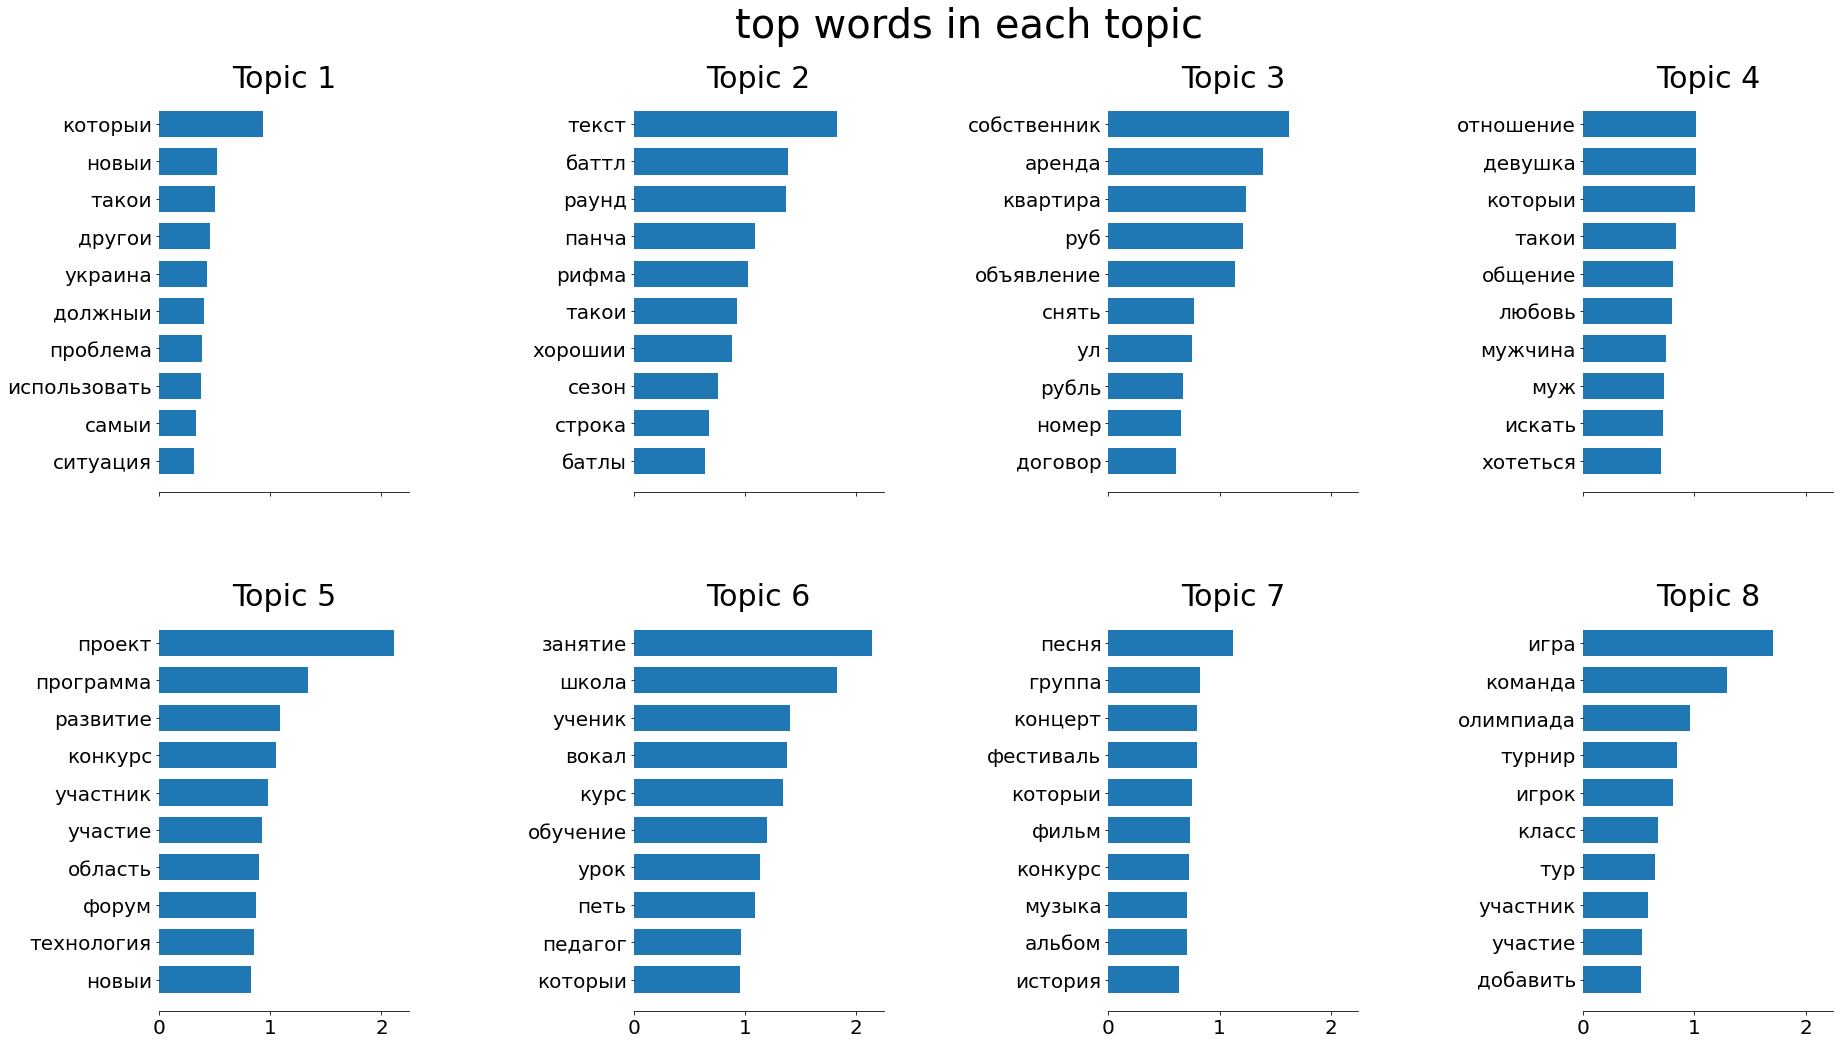

In [6]:
from unicodedata import normalize
import numpy as np

df = pd.read_json('https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.json')
stop_words = list(map(lambda x: normalize('NFKD', x[0]), df.values.tolist()))

# hyperparameters
n_topics = 8

nmf, w, features, vect = get_model(n_topics, stop_words, posts)

plot_top_words(nmf, features, 10, 'top words in each topic')

По топ-словам уже можно разметить темы, а дальше воспользоваться кластеризующим свойством MNF. Но лучше немного расширить список стоп-слов (в глаза бросается `вс`, `чт`, `руб`). Также воспользуемся преимуществом - посчитанной idf для каждого слова из словаря:

C:\Users\mitya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['белыи', 'важныи', 'воина', 'второи', 'выити', 'главныи', 'далекии', 'деиствительно', 'должныи', 'какои', 'которои', 'маленькии', 'многочисленныи', 'мнои', 'мое', 'наити', 'неи', 'некоторыи', 'никакои', 'нужныи', 'подоиди', 'пожалуиста', 'поити', 'последнии', 'пятыи', 'русскии', 'сеаои', 'сеичас', 'случаи', 'советскии', 'старыи', 'твое', 'третии', 'хотел', 'четвертыи', 'шестои'] not in stop_words.
  warnings.warn(


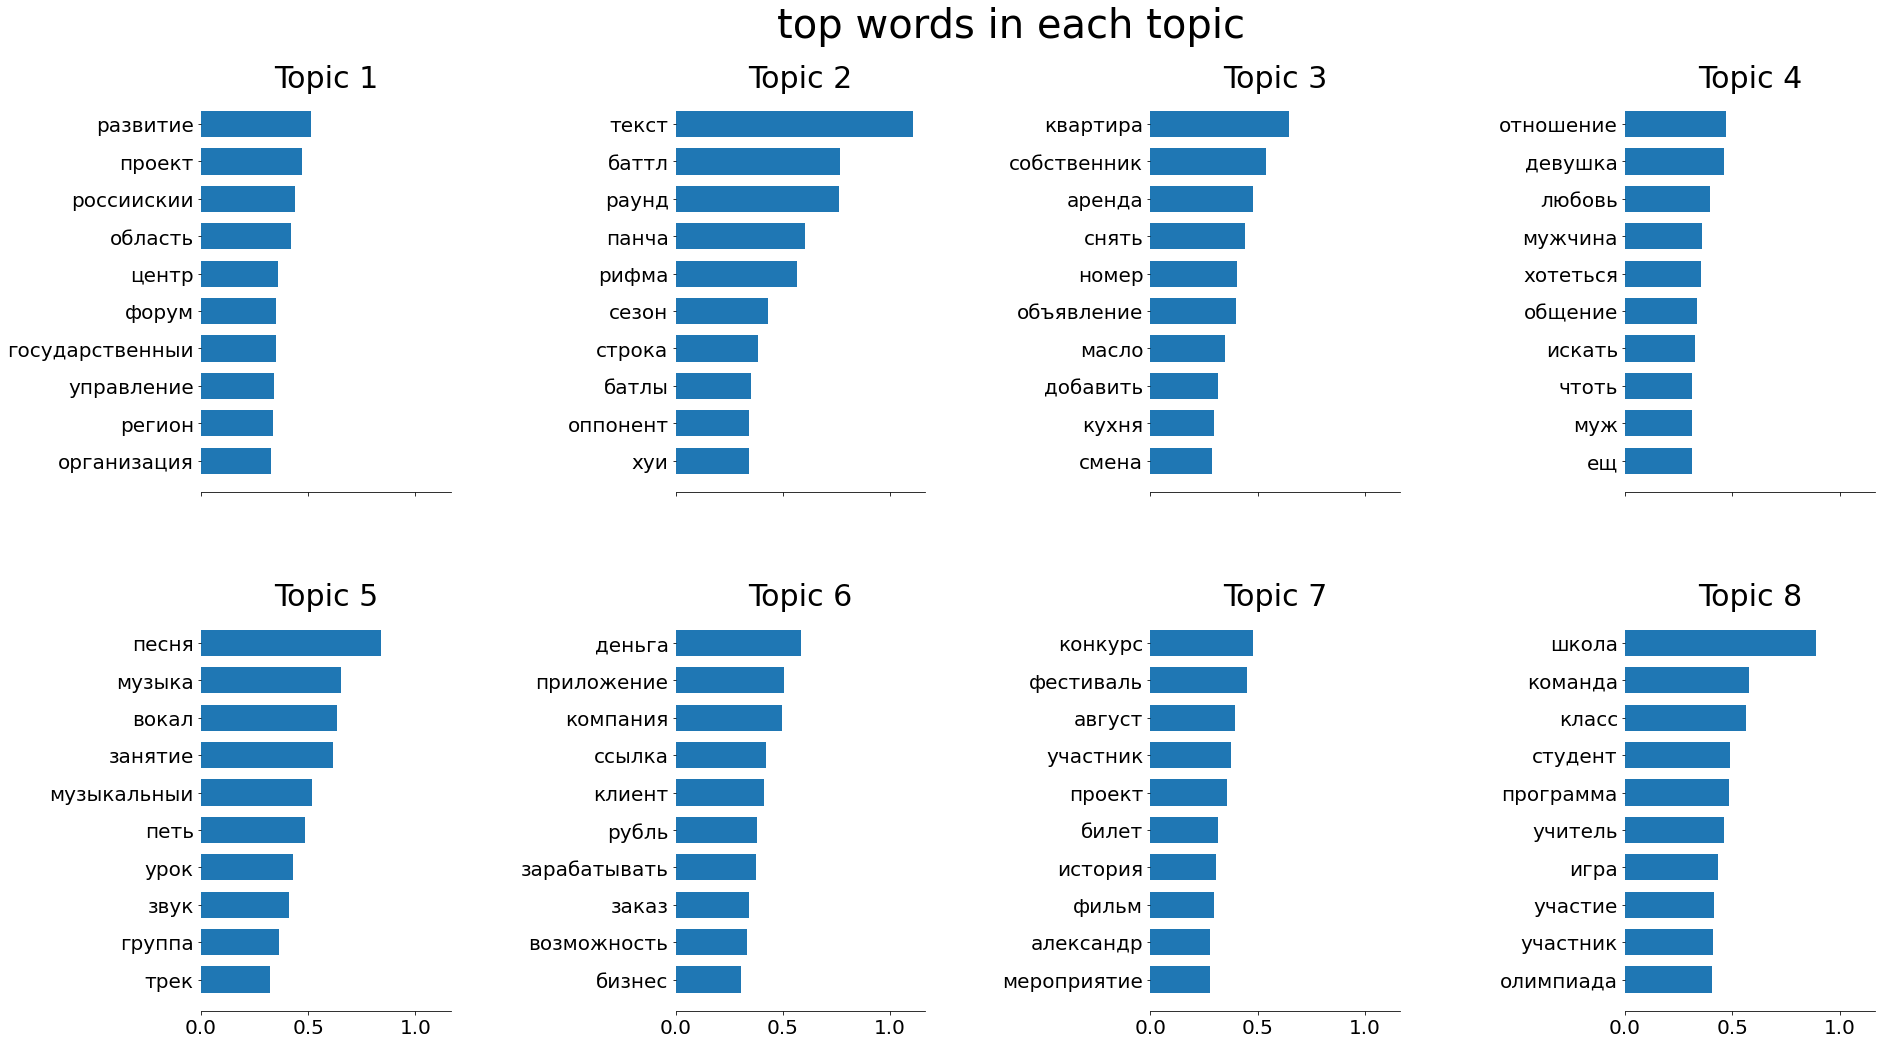

In [7]:
lower_thresh = 2.5
upper_thresh = 6.2

idfs = vect.idf_
rare = idfs <= lower_thresh
often = idfs >= upper_thresh

#mask = not_rare * not_often

stop_words.extend(np.array(features)[rare])
stop_words.extend(np.array(features)[often])
stop_words.extend(['вс', 'чт', 'руб', 'ул', 'эт', 'гд'])

new_nmf, new_w, new_features, _ = get_model(n_topics, stop_words, posts)

plot_top_words(new_nmf, new_features, 10, 'top words in each topic')

Для начала стоит посмотреть, сколько вообще каких текстов получилось:

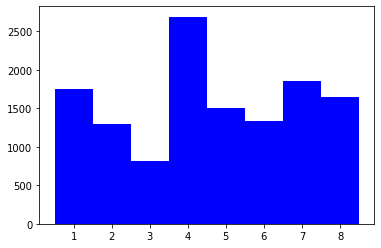

In [8]:
texts = {}

for i in range(1, n_topics+1, 1):
    texts[i] = []
    
for i in range(len(w)):
    topic = np.argmax(new_w[i], axis=0) + 1
    texts[topic].append(posts[i])

text_count = {}    

for i in range(1, n_topics+1, 1):
    #print(f'topic #{i}, count = {len(texts[i])}')
    text_count[i] = len(texts[i])
    
plt.bar(text_count.keys(), text_count.values(), 1.0, color='b')
plt.show()

Имея словарь _тема - список текстов_, можно примерно прикинуть, о чём вообще тексты в неочевидных темах. Для меня такой темой стала тема 7:

In [10]:
def get_texts(n_topic, start, end):
    return texts[n_topic][start:end]

get_texts(7, 200, 202)

['вы только посмотреть какой красивый фотография присылать ребята из царский село на этот неделя они посетить павловск резиденция подарить екатерина сын павел петрович и он супруг мария фдоровня в честь рождение наследник после смерть муж мария фдоровный превратить бывший охотничий угодье в великолепный парк площадь гектар такой образ она выразить свой любовь к муж семья и природа в программа также быть екатерининский и александровский парка и александровский дворец в это год в нм наконецтый открыть зал с горка быть установить в это зал в год горка подарок мать николай он ребёнок она стоять здесь до год царский село это не только дворец и парка в один из день летовца отправиться с экскурсия по город пушкин ведь он история не менее интересный чем история создание дворцовопарковый ансамбль царский село обязательный элемент программа стать поездка в санктпетербург расшифровывать таинственный послание и выполнять задание ребята самостоятельно выстраивать маршрут прогулка который включать в

Немного поигравшись с кодом выше решил, что это что-то про историю или культуру.

Тогда зафиксируем метки топиков:

1. Политика (новости?)
2. Рэп
3. Объявления
4. Знакомства
5. Музыка
6. Финансы, бизнес
7. Культура, история
8. Образование

У такого деления есть очевидный минус: нет темы _другое_.

Из обученной модели остаётся ещё вытащить метку для каждого поста. Проделаем это, результаты можно сохранить в табличку в БД.

In [11]:
import sqlite3

topic_list = [
    (1, 'Политика'),
    (2, 'Рэп'),
    (3, 'Объявления'),
    (4, 'Знакомства'),
    (5, 'Музыка'),
    (6, 'Финансы, бизнес'),
    (7, 'Культура, история'),
    (8, 'Образование')
]

with sqlite3.connect('datasets/posts.db') as conn:
    conn.execute('drop table if exists posts_labeled')
    conn.execute('drop table if exists labels')
    
    conn.execute('create table if not exists labels (id int primary key not null, name varchar(50))')
    conn.executemany('insert into labels values (?, ?)', topic_list)
    conn.commit()
    conn.execute('create table if not exists posts_labeled (text varchar(5000), label_id int not null, foreign key (label_id) references labels(id))')
    for topic, topic_texts in texts.items():
        conn.executemany('insert into posts_labeled values (?, ?)', [(topic, txt) for txt in topic_texts])
        conn.commit()

Дальше остаётся написать классификатор текстов.

## Классификация по выбранным топикам

Идея базируется на изложенном выше и использует преимущество NMF во всей красе. Для построенной через _TF-IDF_ _document-term_ матрциы имеем разложение на две матрицы:

1. _document-feature_ матрица.
2. _feature-term_ матрица.

Последняя хороша тем, что столбцы этой матрицы можно интерпретировать как скоры по топикам для каждого слова из словаря. Будем использовать столбцы этой матрицы в качестве _word embedding_.

В итоге сразу напрашивается следующий подход для построения модели классификатора:

1. Текст каждого поста можно токенизировать, каждый токен (слово) из нашего словаря сопоставляется с нужным столбцом feature-term матрицы.
2. В таком виде текст будет пригоден для RNN и подобных механизмов (LSTM).

Тогда скрытое состояние RNN будет вектором скоров тем. Максимальная компонента - номер подходящей по версии модели темы для текста.

Для начала для каждого слова из словаря стоит сохранить его word embedding. Проделаем это:

In [23]:
import pickle

word_embeddings = {}
# new_features - vocabulary
# new_nmf.components_ - feature-term matrix
#np.shape(new_nmf.components_), np.shape(new_features)

for i in range(len(new_features)):
    word_embeddings[new_features[i]] = list(new_nmf.components_[:, i])
    
with open('model/word_embeddings.bin', 'wb') as file:
    pickle.dump(word_embeddings, file, protocol=pickle.HIGHEST_PROTOCOL)

На этом этапе сохранены предобработанные тексты + word embeddings для каждого слова.

Прежде чем приступать к обучению самой LSTM, зафиксируем слои модели:

1. Препроцессинг + word2vec (кастомный).
2. LSTM.
3. Dense + Dropout.

Подготовим датасет

In [110]:
import sqlite3
import tensorflow as tf

label_ds, text_ds = None, None

with sqlite3.connect('datasets/posts.db') as conn:
    cursor = conn.execute('select * from posts_labeled')
    texts, labels = [], []
    for x in cursor:
        i = int(x[0]) - 1
        texts.append(x[1])
        labels.append(i)
    label_ds = tf.data.Dataset.from_tensor_slices(labels).batch(1)
    text_ds = tf.data.Dataset.from_tensor_slices(texts).batch(1)

all_ds = tf.data.Dataset.zip(text_ds, label_ds)
all_ds = all_ds.shuffle(len(all_ds))
all_ds

<_ShuffleDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [111]:
train_ds, valid_ds, test_ds = all_ds.skip(3000), all_ds.skip(1500).take(1500), all_ds.take(1500)

for t, l in train_ds:
    print(t.shape)
    print(l.shape)
    break
    
print(len(train_ds))

(1,)
(1,)
9902


In [118]:
import pickle
import tensorflow as tf

w2v = {}
with open('model/word_embeddings.bin', 'rb') as file:
    w2v = pickle.load(file)

vocab = list(w2v.keys())
model = tf.keras.Sequential([
    tf.keras.layers.TextVectorization(
        vocabulary=vocab,
        output_sequence_length=1000,
        max_tokens=len(vocab)+2,
        name='text2vec'
    ),
    tf.keras.layers.Embedding(
        input_dim=len(vocab) + 2,
        output_dim=64,
        mask_zero=True,
        name='word_embedding'
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64), name='LSTM'),
    tf.keras.layers.Dense(8, activation='softmax', name='dense')
])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_ds,
                    epochs=30, steps_per_epoch=300, batch_size=32,
                    validation_data=valid_ds,
                    validation_steps=30)

Epoch 1/30
300/300 [==============================] - 127s 405ms/step - loss: 2.0703 - accuracy: 0.1467 - val_loss: 2.0667 - val_accuracy: 0.1333
Epoch 2/30
300/300 [==============================] - 121s 404ms/step - loss: 2.0547 - accuracy: 0.1667 - val_loss: 2.0791 - val_accuracy: 0.2000
Epoch 3/30
300/300 [==============================] - 123s 409ms/step - loss: 2.0169 - accuracy: 0.2267 - val_loss: 2.0486 - val_accuracy: 0.2000
Epoch 4/30
300/300 [==============================] - 123s 411ms/step - loss: 2.0017 - accuracy: 0.2433 - val_loss: 1.8887 - val_accuracy: 0.2333
Epoch 5/30
300/300 [==============================] - 123s 409ms/step - loss: 2.0534 - accuracy: 0.1633 - val_loss: 1.9788 - val_accuracy: 0.2333
Epoch 6/30
300/300 [==============================] - 122s 406ms/step - loss: 2.0105 - accuracy: 0.2367 - val_loss: 1.9635 - val_accuracy: 0.2333
Epoch 7/30
300/300 [==============================] - 123s 411ms/step - loss: 1.9939 - accuracy: 0.2100 - val_loss: 2.0036 -

In [126]:
model.predict(['привет абитуриент олимпиада будет в школа', 'привет абитуриент олимпиада будет в школа'])

1/1 [==============================] - 1s 515ms/step


array([[0.13322636, 0.08668259, 0.09924878, 0.06766138, 0.11763091,
        0.15663023, 0.13880564, 0.20011409],
       [0.13322636, 0.08668259, 0.09924878, 0.06766138, 0.11763091,
        0.15663023, 0.13880564, 0.20011409]], dtype=float32)

In [123]:
model.save('model/model.keras')

Результат для тестовой выборки:

In [125]:
model.evaluate(test_ds, batch_size=32)

1500/1500 [==============================] - 51s 34ms/step - loss: 1.4682 - accuracy: 0.4213


[1.4682012796401978, 0.42133334279060364]

Графики:

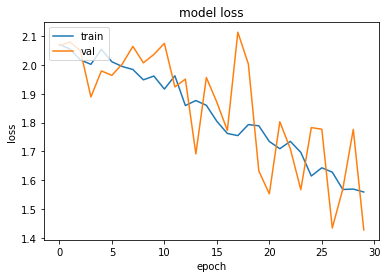

In [127]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

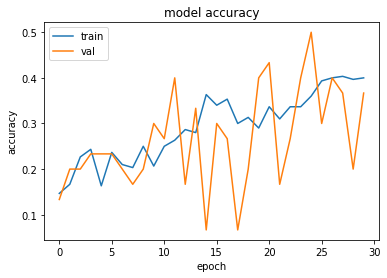

In [128]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()